In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
import svgpathtools as svg

def svg_to_array(svg_path):
    # Read the SVG file
    paths, attributes = svg.svg2paths(svg_path)
    
    # Determine the dimensions of the image
    if 'width' in attributes[0] and 'height' in attributes[0]:
        width = int(attributes[0]['width'].replace('px', ''))
        height = int(attributes[0]['height'].replace('px', ''))
    elif 'viewBox' in attributes[0]:
        viewBox = attributes[0]['viewBox'].split(' ')
        width = int(viewBox[2])
        height = int(viewBox[3])
    else:
        width, height = 512, 512  # Default size if width and height are not specified
    
    # Create a blank canvas
    image = np.ones((height, width, 3), dtype=np.uint8) * 255
    
    # Plot the SVG paths onto the canvas
    fig, ax = plt.subplots()
    
    for path in paths:
        for segment in path:
            x = [segment.start.real, segment.end.real]
            y = [segment.start.imag, segment.end.imag]
            ax.plot(x, y, 'k-')  # 'k-' means black lines
    
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Flip the y-axis to match SVG coordinate system
    ax.axis('off')
    
    fig.canvas.draw()
    
    # Convert the plot to a numpy array
    image = np.array(fig.canvas.renderer.buffer_rgba())
    
    plt.close(fig)
    
    # Remove alpha channel
    image = image[:, :, :3]
    
    return image

# Paths for the input and output SVG images
input_svg_path = 'problems/frag0.svg'
output_svg_path = 'problems/frag01_sol.svg'

# Convert SVG to numpy arrays
input_image = svg_to_array(input_svg_path)
output_image = svg_to_array(output_svg_path)

# Define the encoder
def build_encoder(input_layer):
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    return pool3, conv1, conv2, conv3

# Define the decoder
def build_decoder(encoded, conv1, conv2, conv3):
    up3 = UpSampling2D((2, 2))(encoded)
    concat3 = concatenate([up3, conv3])
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    
    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = concatenate([up2, conv2])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    
    up1 = UpSampling2D((2, 2))(conv5)
    concat1 = concatenate([up1, conv1])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv6)
    
    return output_layer

# Build the model
def build_model(input_shape):
    input_layer = Input(shape=input_shape)
    encoded, conv1, conv2, conv3 = build_encoder(input_layer)
    output_layer = build_decoder(encoded, conv1, conv2, conv3)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define input shape based on loaded images
input_shape = input_image.shape
model = build_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
X_train = np.expand_dims(input_image, axis=0)  # Add batch dimension
Y_train = np.expand_dims(output_image, axis=0)  # Add batch dimension

model.fit(X_train, Y_train, epochs=50, batch_size=1)  # Training with a batch size of 1 since we have only one pair


Epoch 1/50

1/1 [==============================] - 13s 13s/step - loss: 64306.2266
Epoch 2/50
1/1 [==============================] - 11s 11s/step - loss: 63975.1914
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: 63974.0391
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: 63974.0391
Epoch 5/50
1/1 [==============================] - 13s 13s/step - loss: 63974.0391
Epoch 6/50
1/1 [==============================] - 12s 12s/step - loss: 63974.0391
Epoch 7/50
1/1 [==============================] - 11s 11s/step - loss: 63974.0391
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: 63973.7734
Epoch 9/50
1/1 [==============================] - 13s 13s/step - loss: 63973.7734
Epoch 10/50
1/1 [==============================] - 13s 13s/step - loss: 63973.7734
Epoch 11/50
1/1 [==============================] - 11s 11s/step - loss: 63973.7734
Epoch 12/50
1/1 [==============================] - 11s 11s/step - loss: 63973.7734
Epoch 13/50

1/1 [==============================] - 2s 2s/step


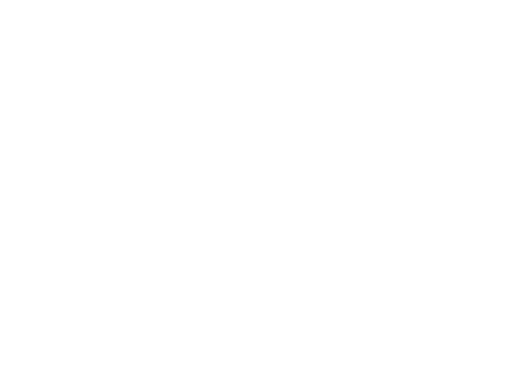

In [9]:

# Function to test the model
def test_model(svg_path, model):
    # Preprocess the SVG image
    test_image = svg_to_array(svg_path)
    test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
    
    # Predict using the trained model
    predicted_image = model.predict(test_image)
    
    # Post-process the output
    predicted_image = np.squeeze(predicted_image)  # Remove batch dimension
    predicted_image = (predicted_image * 255).astype(np.uint8)  # Rescale to 0-255 and convert to uint8
    
    return predicted_image

# Test the model with a new SVG image
test_svg_path = 'problems/frag1.svg'  # Path to your test SVG file
predicted_output = test_model(test_svg_path, model)

# Visualize the output
plt.imshow(predicted_output)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
import svgpathtools as svg
import os

def svg_to_array(svg_path):
    # Read the SVG file
    paths, attributes = svg.svg2paths(svg_path)
    
    # Determine the dimensions of the image
    if 'width' in attributes[0] and 'height' in attributes[0]:
        width = int(attributes[0]['width'].replace('px', ''))
        height = int(attributes[0]['height'].replace('px', ''))
    elif 'viewBox' in attributes[0]:
        viewBox = attributes[0]['viewBox'].split(' ')
        width = int(viewBox[2])
        height = int(viewBox[3])
    else:
        width, height = 512, 512  # Default size if width and height are not specified
    
    # Create a blank canvas
    image = np.ones((height, width, 3), dtype=np.uint8) * 255
    
    # Plot the SVG paths onto the canvas
    fig, ax = plt.subplots()
    
    for path in paths:
        for segment in path:
            x = [segment.start.real, segment.end.real]
            y = [segment.start.imag, segment.end.imag]
            ax.plot(x, y, 'k-')  # 'k-' means black lines
    
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Flip the y-axis to match SVG coordinate system
    ax.axis('off')
    
    fig.canvas.draw()
    
    # Convert the plot to a numpy array
    image = np.array(fig.canvas.renderer.buffer_rgba())
    
    plt.close(fig)
    
    # Remove alpha channel
    image = image[:, :, :3]
    
    return image

def load_images_from_directory(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.svg'):
            image_path = os.path.join(directory, filename)
            image = svg_to_array(image_path)
            images.append(image)
    return np.array(images)

def build_encoder(input_layer):
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    return pool3, conv1, conv2, conv3

def build_decoder(encoded, conv1, conv2, conv3):
    up3 = UpSampling2D((2, 2))(encoded)
    concat3 = concatenate([up3, conv3])
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    
    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = concatenate([up2, conv2])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    
    up1 = UpSampling2D((2, 2))(conv5)
    concat1 = concatenate([up1, conv1])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv6)
    
    return output_layer

def build_model(input_shape):
    input_layer = Input(shape=input_shape)
    encoded, conv1, conv2, conv3 = build_encoder(input_layer)
    output_layer = build_decoder(encoded, conv1, conv2, conv3)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Load multiple input and output images
input_images = load_images_from_directory('input_svg')
output_images = load_images_from_directory('output_svg')

# Define input shape based on loaded images
input_shape = input_images.shape[1:]  # (height, width, channels)
model = build_model(input_shape)

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Check shapes of the training data
print(f'X_train shape: {input_images.shape}')
print(f'Y_train shape: {output_images.shape}')

# Train the model
model.fit(input_images, output_images, epochs=50, batch_size=4)  # Adjust batch_size if needed

def test_model(svg_path, model):
    # Preprocess the SVG image
    test_image = svg_to_array(svg_path)
    test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
    
    # Predict using the trained model
    predicted_image = model.predict(test_image)
    
    # Post-process the output
    predicted_image = np.squeeze(predicted_image)  # Remove batch dimension
    predicted_image = (predicted_image * 255).astype(np.uint8)  # Rescale to 0-255 and convert to uint8
    
    return predicted_image



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 480, 640, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 240, 320, 64)         0         ['conv2d_22[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 240, 320, 128)        73856     ['max_pooling2d_12[0][0]

Test image shape: (1, 480, 640, 3)
1/1 [==============================] - 2s 2s/step


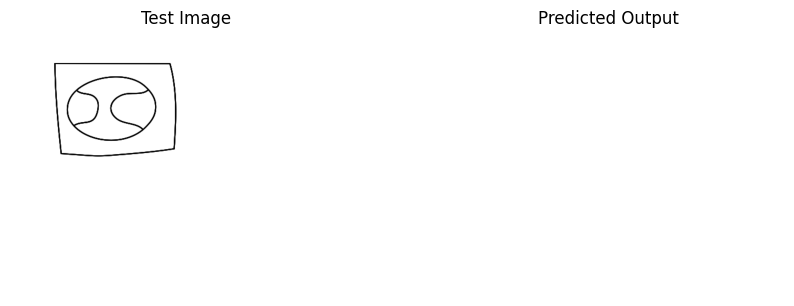

In [11]:

# Test the model with a new SVG image
test_svg_path = 'problems/frag0.svg'  # Path to your test SVG file
predicted_output = test_model(test_svg_path, model)

# Debug: Visualize the test image and the predicted output
test_image = svg_to_array(test_svg_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_output)
plt.title('Predicted Output')
plt.axis('off')
plt.show()